Relax Data Challenge

Completed by Carolyn MASSA on April 20, 2020


This exercise is essentiall defining an "adopted user" as a user who has logged into the product on three separate
days in at least one sevenday period , identify which factors predict future user adoption.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [116]:
from sklearn.ensemble import RandomForestClassifier
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

#Data Collection and Cleaning

In [39]:
users = pd.read_csv("takehome_users.csv", engine='python')
users_engagement = pd.read_csv("takehome_user_engagement.csv", engine='python')

In [40]:
users.head(5)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [41]:
users_engagement.head(5)

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [42]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB




We immediately notice that creation_time and last_session_creation_time are both time stamp data and need to be  converted to datatime types. The missing values in last_session_creation_time need to be filled with their corresponding creation_time's column.

We leave the invited_by_user_id those users who were created not though an invitation.


In [44]:
users_engagement.visited.value_counts()

1    207917
Name: visited, dtype: int64

In [45]:
import datetime

#set the time_stamp to datetime and the set it as the index
users_engagement.time_stamp = pd.to_datetime(users_engagement.time_stamp)
users_engagement = users_engagement.set_index('time_stamp', drop= True)

Our rules for user engagement are when a person logs in 3 x in 7 days so since there is only a 1 we will delete this variable and convert the times

# Data Exploration - Now let's find the engaged users 


In [46]:
from datetime import timedelta

def user_adopted(x):    
    "takes a users input and returns whether or not they have been active within any 7-day period"
    df_users = users_engagement.loc[users_engagement['user_id'] == x] #select out rows of this user
    df_users = df_users.resample('D').mean().dropna() #resample to show if active in a day. .mean() is just of 1
    adopted = 0
    for i in range(len(df_users)-2): #loop over active days till the second to last day
        if df_users.index[i + 2] - df_users.index[i] <= timedelta(days=7): # difference between every 1st and 3rd day
            adopted = 1
            break
        else:
            adopted = 0
    return adopted

In [47]:
users['adopted_user'] = users['object_id'].apply(user_adopted)

In [48]:
print(sum(users['adopted_user']))
print(sum(users.adopted_user)/len(users.adopted_user))

1656
0.138


Of the total number of users which is 12000 only 13.8% of them have adopted to our platform

We not need to review our time formats to conduct further analysis as our concern is user adoption which is measured by log=ins


In [49]:
# set creation_time
users.creation_time = pd.to_datetime(users.creation_time)
#last_session_creation_time is a unix time stamp, so use map to convert to datetime
users['last_session_creation_time'] = users['last_session_creation_time'].map(lambda data: 
                                    datetime.datetime.fromtimestamp(int(data)).strftime('%Y-%m-%d %H:%M:%S'),
                                                                              na_action='ignore')

#now we must see how long the User has been active from the time they opened their account from their last session


In [68]:
#we set it to datetime
users['last_session_creation_time'] = pd.to_datetime(users['last_session_creation_time'])
#subtract to find time active
users['usage_length'] = users['last_session_creation_time'] - users['creation_time']
#lets settle for seconds instead of days to make the time differences more distinct
users['usage_length'] = [x.total_seconds() for x in users['usage_length']]

In [78]:
users.head(5)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,email_domain,usage_length
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 05:53:30,1,0,11,10803.0,0,yahoo.com,7200.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 05:45:04,0,0,1,316.0,1,gustr.com,11757600.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-20 00:14:52,0,0,94,1525.0,0,gustr.com,3600.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 10:09:28,0,0,1,5151.0,0,yahoo.com,93600.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 11:14:20,0,0,193,5240.0,0,yahoo.com,435600.0


In [70]:
users.head(5)

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,email_domain,usage_length
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 05:53:30,1,0,11,10803.0,0,yahoo.com,7200.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 05:45:04,0,0,1,316.0,1,gustr.com,11757600.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-20 00:14:52,0,0,94,1525.0,0,gustr.com,3600.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 10:09:28,0,0,1,5151.0,0,yahoo.com,93600.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 11:14:20,0,0,193,5240.0,0,yahoo.com,435600.0


# Here I create a new data frame to apply a CHI SQUARE TEST to in order to test for email domain significance

In [140]:
df2 = users[['email', 'adopted_user']].copy() #I create a new dataframe to include just Email Domian and Adopted User to apply to my CHI SQUARE test
df2.head(5)

,email,adopted_user
0,AugustCClausen@yahoo.com,0
1,MatthewPoole@gustr.com,1
2,MitchellBottrill@gustr.com,0
3,NicklasSClausen@yahoo.com,0
4,GraceRaw@yahoo.com,0


H0:  There is not relevance in the email domain of the users in weather they adopted to the service or not
HA:  The email domain name plays a role in whether the user adopted the service or not.

In [142]:

from scipy import stats

df_chi = df2 #Here I wish to apply my dataframe above to my CHI SQUARE TEST to see the relationship between Gender and Churn
contingency_table=pd.crosstab(df_chi["email"],df_chi["adopted_user"])
print('contingency_table :-\n',contingency_table)
#Observed Values
Observed_Values = contingency_table.values 
print("Observed Values :-\n",Observed_Values)
b=stats.chi2_contingency(contingency_table)
Expected_Values = b[3]
print("Expected Values :-\n",Expected_Values)
no_of_rows=len(contingency_table.iloc[0:2,0])
no_of_columns=len(contingency_table.iloc[0,0:2])
ddof=(no_of_rows-1)*(no_of_columns-1)
print("Degree of Freedom:-",ddof)
alpha = 0.05
from scipy.stats import chi2
chi_square=sum([(o-e)**2./e for o,e in zip(Observed_Values,Expected_Values)])
chi_square_statistic=chi_square[0]+chi_square[1]
print("chi-square statistic:-",chi_square_statistic)
critical_value=chi2.ppf(q=1-alpha,df=ddof)
print('critical_value:',critical_value)
#p-value
p_value=1-chi2.cdf(x=chi_square_statistic,df=ddof)
print('p-value:',p_value)
print('Significance level: ',alpha)
print('Degree of Freedom: ',ddof)
print('chi-square statistic:',chi_square_statistic)
print('critical_value:',critical_value)
print('p-value:',p_value)
if chi_square_statistic>=critical_value:
    print("Reject H0,There is a relationship between 2 categorical variables")
else:
    print("Retain H0,There is no relationship between 2 categorical variables")
    
if p_value<=alpha:
    print("Reject H0,There is a relationship between 2 categorical variables")
else:
    print("Retain H0,There is no relationship between 2 categorical variables")

contingency_table :-
 adopted_user                 0  1
email                            
AaliyahArmstrong@yahoo.com   1  0
AaliyahGibbs@gustr.com       1  0
AaliyahHeath@jourrapide.com  0  1
AaliyahIqbal@gustr.com       1  0
AaliyahMarshall@yahoo.com    1  0
...                         .. ..
zvgswfkk@utjmk.com           1  0
zwicjnqn@ruynp.com           1  0
zxswdasp@swhrr.com           1  0
zyxoffkk@vxdvt.com           1  0
zzxqnoiy@vhugu.com           1  0

[11980 rows x 2 columns]
Observed Values :-
 [[1 0]
 [1 0]
 [0 1]
 ...
 [1 0]
 [1 0]
 [1 0]]
Expected Values :-
 [[0.862 0.138]
 [0.862 0.138]
 [0.862 0.138]
 ...
 [0.862 0.138]
 [0.862 0.138]
 [0.862 0.138]]
Degree of Freedom:- 1
chi-square statistic:- 11987.39029557239
critical_value: 3.841458820694124
p-value: 0.0
Significance level:  0.05
Degree of Freedom:  1
chi-square statistic: 11987.39029557239
critical_value: 3.841458820694124
p-value: 0.0
Reject H0,There is a relationship between 2 categorical variables
Reject H0,There

From the results above I reject my HO and go with the HA that "EMAIL DOMAIN does have an impact in weather a customer adopted the service"

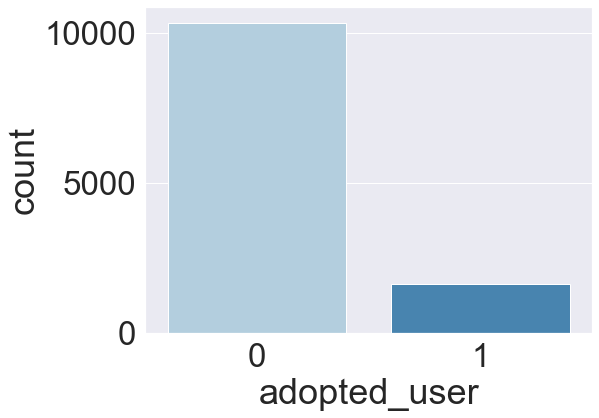

In [112]:
fig_dims = (8, 6)
fig, ax = plt.subplots(figsize=fig_dims)
sns.countplot(x="adopted_user", palette="Blues", data=users) # we see a very low rate of adoption = only 13.8%
plt.show()

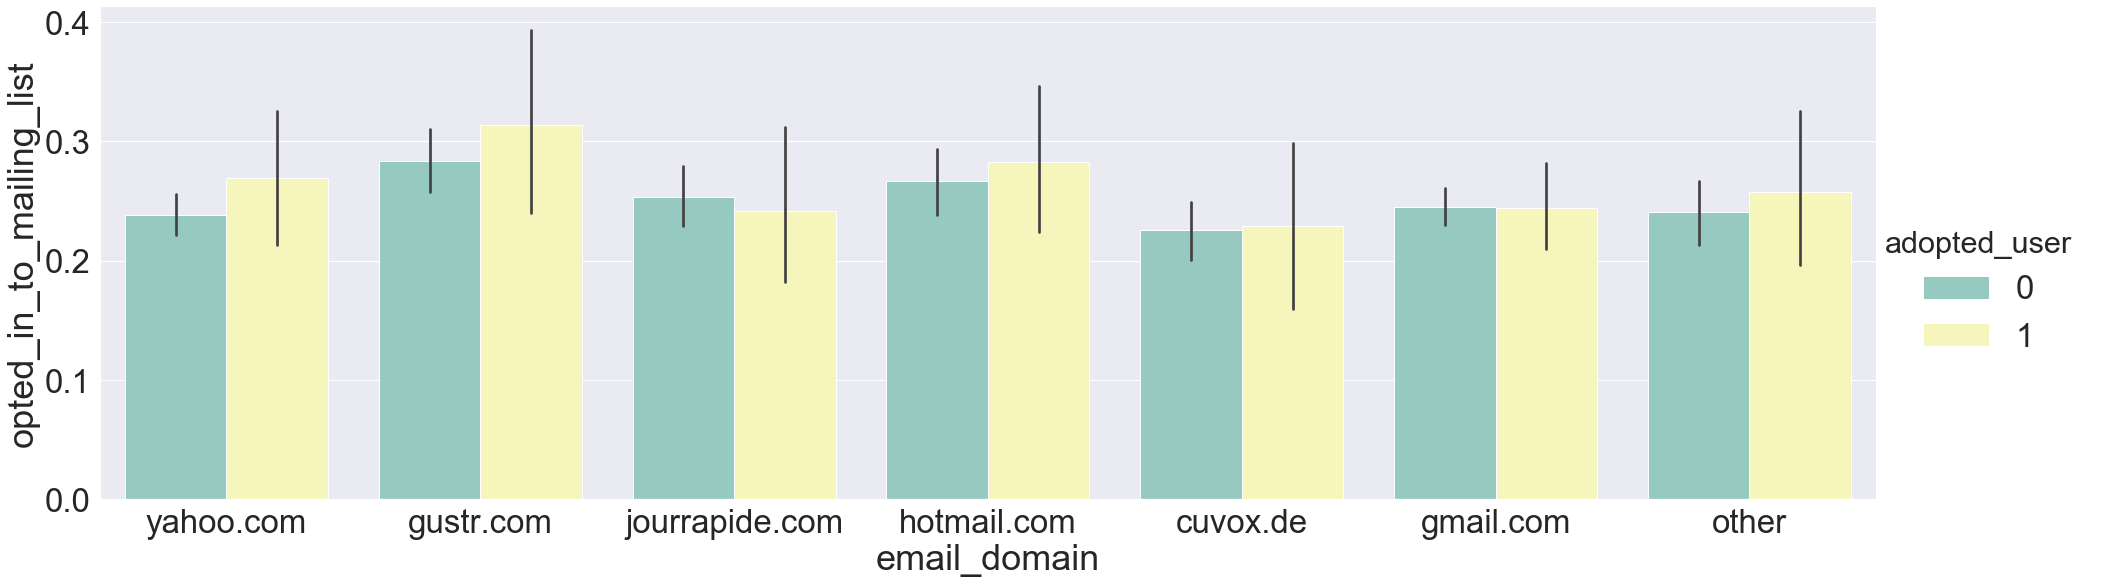

In [88]:
import seaborn as sns #Here we can see who wnated to be added to the mailing list and which domain they used by adoption
sns.set(font_scale=3)
sns.catplot(x='email_domain', y='opted_in_to_mailing_list', hue='adopted_user', data=users, kind='bar',height=9, aspect=3, palette="Set3")

In [55]:
users.invited_by_user_id = users.invited_by_user_id.fillna(0) #Here we fill the values of those who were not invited by a user

In [ ]:
#Let's look at the user's email domains to see if that can contribute to retention

In [61]:
users['email_domain'] = [x.split('@')[1] for x in users.email]#select out the domain by splitting at the @
top_domains = users.email_domain.value_counts().index[:6]
#label anything not in the top 5 as other
users['email_domain'] = [x if x in top_domains else 'other' for x in users.email_domain]

#I see that a few variables will not be useful for my model hence I drop them

In [57]:
df_Vars = users.iloc[:,4:]
df_Vars = df_Vars.drop('last_session_creation_time', axis=1)
df_Vars['usage_length'] = df_Vars['usage_length'].fillna(0)

I read about the advantages of sklearn label encoder over get dummies and one hot encoderin terms of 
preserving space so I use this to transform my data into data types suitable for running my models.


In [63]:
from sklearn.preprocessing import LabelEncoder

gle = LabelEncoder()
source_creation = gle.fit_transform(users['creation_source'])
df_Vars.creation_source = source_creation

labels_original_id = gle.fit_transform(users['org_id'])
df_Vars.org_id = labels_original_id

labels_invitation = gle.fit_transform(users['invited_by_user_id'])
df_Vars.invited_by_user_id = labels_invitation

labels_email = gle.fit_transform(users['email_domain'])
df_Vars.email_domain = labels_email

In [ ]:
https://github.com/carmagnole/Springboard-RelaxChallenge/blob/master/.ipynb_checkpoints/analysis-checkpoint.ipynb

In [64]:
df_Vars.head(5)

,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,email_domain,usage_length
0,0,1,0,11,2325,0,6,7200.0
1,1,0,0,1,56,1,2,11757600.0
2,1,0,0,94,298,0,2,3600.0
3,0,0,0,1,1104,0,6,93600.0
4,0,0,0,193,1127,0,6,435600.0


We have both numerical and categorical data as well as a relatively small data set so we will use Random Forest for our model as well as 

In [ ]:
#Let's now split our data set into training and test

In [120]:
from sklearn.model_selection import train_test_split

#set up data by seperating out the labels, then we split for cross validation
df = df_Vars.drop('adopted_user', axis=1)
labels = df_Vars.adopted_user

X_train, y_train, X_test, y_test = train_test_split(df, labels, test_size=0.33, random_state=42)

In [131]:
rf = RandomForestClassifier(class_weight='balanced_subsample',n_estimators=100,n_jobs=-1, random_state=42)

rf.fit(X_train, X_test)

rf.score(y_train, y_test)

0.972979797979798

In [132]:
y_pred = rf.predict(y_train)


              precision    recall  f1-score   support

           0       0.98      0.99      0.98      3407
           1       0.92      0.88      0.90       553

    accuracy                           0.97      3960
   macro avg       0.95      0.93      0.94      3960
weighted avg       0.97      0.97      0.97      3960

confusion matrix:
[[3366   41]
 [  66  487]]


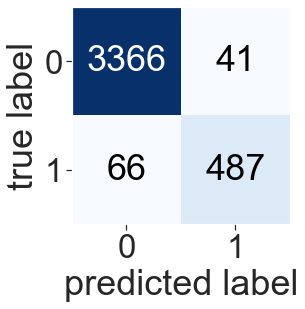

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      3407
           1       0.92      0.88      0.90       553

    accuracy                           0.97      3960
   macro avg       0.95      0.93      0.94      3960
weighted avg       0.97      0.97      0.97      3960



In [139]:
print(classification_report(y_test, y_pred))

cm= confusion_matrix(y_test,y_pred)
print('confusion matrix:')
print(cm)

fig, ax = plot_confusion_matrix(cm)
plt.show()
print(classification_report(y_test, y_pred))

we have very meaningful results in this model as a .97 weighted accuracy is outstanding in our report

For our confusion Matrix we also have good results:

    high precision: how many predicted as 1 are actually 1: 487/(41+487) = 0.92
    high recall : of all true 1s, how much are predicted as 1: 487/(66+487) = 0.88


In [136]:
feature_importance = pd.DataFrame()
feature_importance['coef'] = rf.feature_importances_
feature_importance = feature_importance.set_index(df.columns)
feature_importance.coef.nlargest(10)

usage_length                  0.897089
org_id                        0.048307
invited_by_user_id            0.022743
email_domain                  0.014551
creation_source               0.010656
opted_in_to_mailing_list      0.003428
enabled_for_marketing_drip    0.003226
Name: coef, dtype: float64

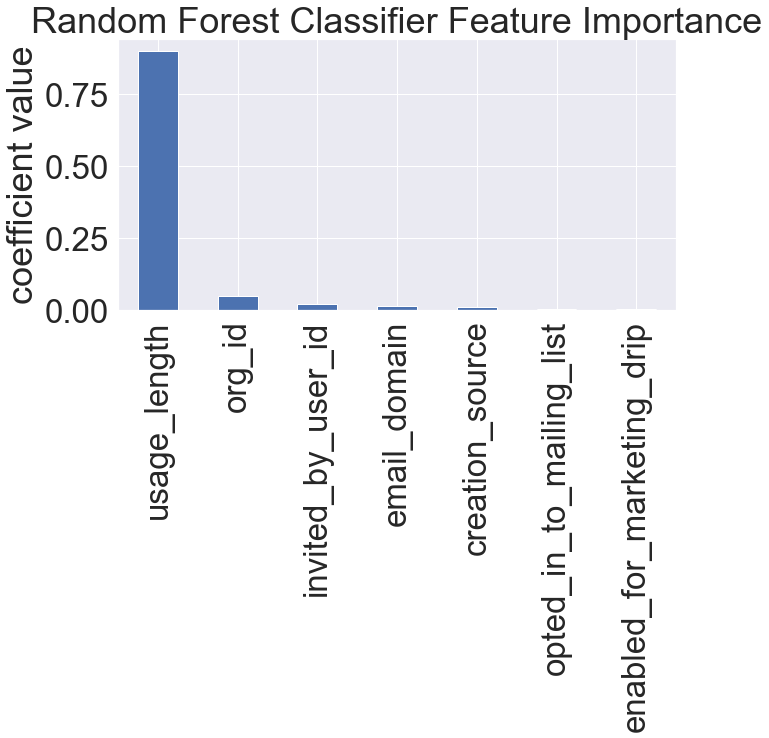

In [137]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,7))
(feature_importance['coef']).nlargest(10).plot(kind='bar', x=feature_importance.index)
plt.title('Random Forest Feature Importance')
plt.ylabel('coefficient values')
plt.show()



Let's review our plot results above

    The Rider's useage length is the most important feature
    If they were invited by a user, original ID were high indicators of future user adoption than rest of the categories
   


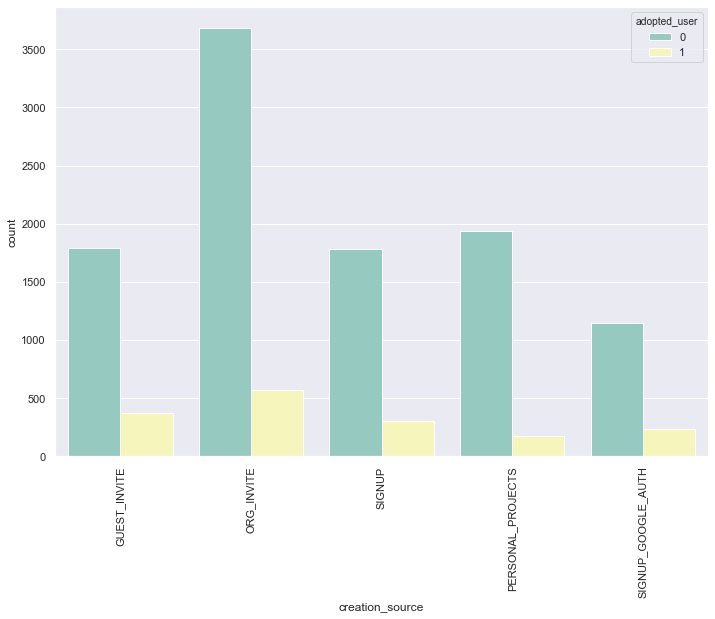

In [157]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.countplot( x="creation_source",  hue='adopted_user', data =users, palette="Set3");
plt.xticks(rotation =90)
plt.show()

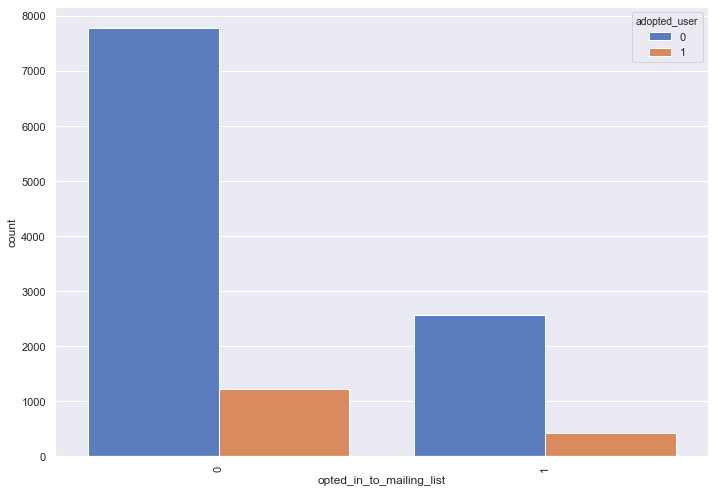

In [160]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.countplot( x="opted_in_to_mailing_list",  hue='adopted_user', data =users, palette= "muted");
plt.xticks(rotation =90)
plt.show()

<html><head>
    
    Final Thoughts


#For predicting future user adoption:
</script>
</head>

<body>
    <ol>
    
    useagelength: #1 Critical Feature. This feature takes the login time minus the creation time.
        
     original ID: this is a part of a group or orginization that the user belongs to; it's mission critical for a company
    to retain large groups and provide a good experience to retrain groups as most users may talk to each other and if
    not satisfied will leave the service </li>
        
    some creation source, for example, personal project might be more indicative of adoption or not than others, which can be shown from important features plot; while the organization invites has the total largest number of adopted users, and guest invites might have the 2nd largest proportion of adopted users. Depending on objectives we want to achieve, whether to increase the proportion or the total numbers of adoption, we might want to put into our efforts in promoting different sign-up strategies accordingly 
    
    opted_in_to_mailing_list,  and enabled_for_marketing_drip are generally weak in the RF model prediction but could be reviewed and scrutized for their effectiveness.
    
</ol>
</body>
</html>


